In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
import statsmodels.formula.api as smf
import numpy as np
%matplotlib inline

In [2]:
sentiment = pd.read_csv('consumer_sentiment.csv')

In [3]:
sentiment

,CASEID,YYYYMM,YYYYQ,YYYY,ID,IDPREV,DATEPR,ICS,ICC,ICE
0,1,197801,19781,1978,1,,,76.71,116.23,51.32
1,2,197801,19781,1978,2,,,121.12,154.08,99.94
2,3,197801,19781,1978,3,,,2.70,2.70,2.70
3,4,197801,19781,1978,4,,,76.71,154.08,27.01
4,5,197801,19781,1978,5,,,121.12,116.23,124.25
...,...,...,...,...,...,...,...,...,...,...
312726,312727,202307,20233,2023,2097,1130,202301,31.60,39.84,26.31
312727,312728,202307,20233,2023,2098,1038,202301,76.01,153.38,26.31
312728,312729,202307,20233,2023,2099,1141,202301,61.21,115.53,26.31
312729,312730,202307,20233,2023,2100,1071,202301,90.81,77.69,99.24


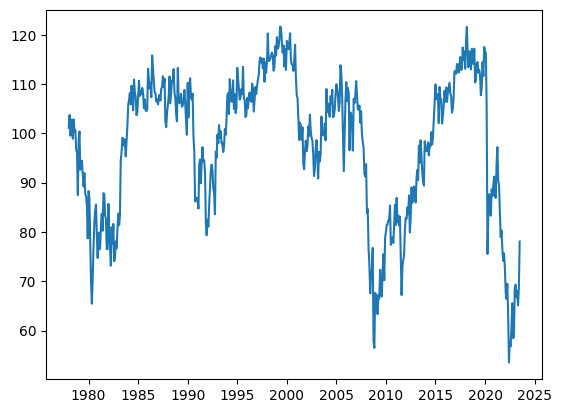

In [4]:
sentiment['DATE'] = pd.to_datetime(sentiment.YYYYMM, format="%Y%m")

sentiment_by_month = sentiment.groupby(['DATE']).ICC.mean()

plt.plot(sentiment_by_month)
plt.show()

In [5]:
unemployment = pd.read_csv("unemployment_rate.csv")
unemployment['DATE'] = pd.to_datetime(unemployment.DATE)
unemployment = unemployment.set_index('DATE')
inflation = pd.read_csv("inflation.csv")
inflation['DATE'] = pd.to_datetime(inflation.DATE)
inflation = inflation.set_index('DATE')
interest_rates = pd.read_csv("interest_rates.csv")
interest_rates['DATE'] = pd.to_datetime(interest_rates['DATE'])
interest_rates = interest_rates.set_index('DATE')

In [6]:
data = pd.DataFrame(data={"sentiment": sentiment_by_month, 
                          "inflation": inflation.CORESTICKM159SFRBATL, 
                          "unemployment": unemployment.UNRATE,
                          "rates": interest_rates.DFF}).dropna()

In [7]:
def norm(series):
    return (series-series.mean())/series.std()

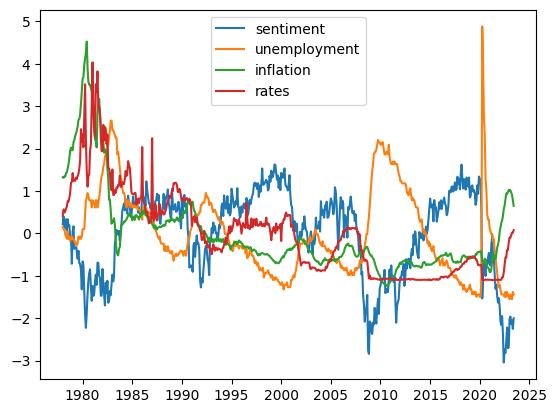

In [8]:
plt.plot(norm(data.sentiment))
plt.plot(norm(data.unemployment))
plt.plot(norm(data.inflation))
plt.plot(norm(data.rates))
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates'])
plt.show()

In [9]:
def try_model(data, form):
    data_precovid = data[data.index < '2020-02-01']
    model_80s = smf.ols(formula=form, data=data, subset=data.index < '1990').fit()
    model_precovid = smf.ols(formula=form, data=data, subset=data.index < '2020-02-01').fit()
    model_full = smf.ols(formula=form, data=data).fit()
    plt.plot(data.sentiment)
    for name, model in zip(["80s", "Pre-Covid", "Full"], [model_80s, model_precovid, model_full]):
        print(f"Model {name}")
        print(model.summary())
        plt.plot(model.predict(data))
    plt.axhline(y = 100, color='lightgrey')
    plt.legend(['sentiment', '80s', 'pre-covid', 'full', 'neutral'])
    plt.title(f"Model {form}")
    plt.show()

In [ ]:
try_model(data, "sentiment ~ inflation + unemployment")

In [ ]:
try_model(data, "sentiment ~ inflation + unemployment + rates")

In [ ]:
plt.plot(norm(data.sentiment))
plt.plot(norm(data.unemployment.rolling(24).mean()))
plt.plot(norm(data.inflation.rolling(24).mean()))
plt.plot(norm(data.rates.rolling(24).mean()))
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates'])
plt.title("24 month rolling average")
plt.show()

In [ ]:
data['uenmployment_12_month'] = data.unemployment.rolling(12).mean()
data['inflation_12_month'] = data.inflation.rolling(12).mean()
data['rates_12_month'] = data.rates.rolling(12).mean()

In [ ]:
try_model(data, "sentiment ~ inflation + unemployment + rates + uenmployment_12_month + inflation_12_month + rates_12_month")

In [ ]:
data['uenmployment_24_month'] = data.unemployment.rolling(24).mean()
data['inflation_24_month'] = data.inflation.rolling(24).mean()
data['rates_24_month'] = data.rates.rolling(24).mean()
try_model(data, "sentiment ~ inflation + unemployment + rates + uenmployment_24_month + inflation_24_month + rates_24_month")

In [ ]:
plt.plot(norm(data.sentiment))
plt.plot(norm(data.unemployment.rolling(24).std()))
plt.plot(norm(data.inflation.rolling(24).std()))
plt.plot(norm(data.rates.rolling(24).std()))
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates'])
plt.title("Volatility")
plt.show()

In [ ]:
data['uenmployment_volatility'] = data.unemployment.rolling(24).std()
data['inflation_volatility'] = data.inflation.rolling(24).std()
data['rates_volatility'] = data.rates.rolling(24).std()
try_model(data,  "sentiment ~ inflation + unemployment + rates + uenmployment_volatility + inflation_volatility + rates_volatility")

In [ ]:
try_model(data,"sentiment ~ inflation + unemployment + uenmployment_volatility + inflation_volatility")

In [ ]:
try_model(data, "sentiment ~ inflation * unemployment * rates")

In [ ]:
try_model(data, "sentiment ~ (inflation+unemployment+rates)**2")

In [ ]:
try_model(data, "sentiment ~ inflation * unemployment * rates * inflation_volatility * uenmployment_volatility * rates_volatility")

In [ ]:
try_model(data, "sentiment ~ (inflation + unemployment + rates + inflation_volatility + uenmployment_volatility + rates_volatility)**2")

In [ ]:
try_model(data, "sentiment ~ (inflation + unemployment + inflation_volatility + uenmployment_volatility)**2")

In [ ]:
model = smf.ols(formula="sentiment ~ inflation + unemployment + rates + uenmployment_volatility + inflation_volatility + rates_volatility", data=data).fit()

In [ ]:
model.summary()

In [ ]:
plt.plot(data.sentiment)
plt.plot(model.predict(data))
plt.show()

In [ ]:
plt.scatter(x=model.fittedvalues, y=model.resid)

In [ ]:
model = smf.ols(formula="np.log(sentiment) ~ inflation + unemployment + rates + uenmployment_volatility + inflation_volatility + rates_volatility", data=data).fit()

In [ ]:
model.summary()

In [ ]:
plt.plot(data.sentiment)
plt.plot(np.exp(model.predict(data)))

In [ ]:
plt.scatter(x=model.fittedvalues, y=model.resid)

In [ ]:
try_model(form="sentiment ~ (inflation + unemployment + inflation_volatility + uenmployment_volatility)**2", data=data)

In [ ]:
model = smf.ols(formula="sentiment ~ (inflation + unemployment + inflation_volatility + uenmployment_volatility)**2", data=data).fit()

In [ ]:
model.summary()

In [ ]:
plt.plot(data.sentiment)
plt.plot(model.predict(data))

In [ ]:
plt.scatter(x=model.fittedvalues, y=model.resid)

In [ ]:
data['sentiment_move'] = data.sentiment - data.sentiment.rolling(12).mean()

In [ ]:
plt.plot(data.sentiment_move)

In [ ]:
model = smf.ols(formula="sentiment_move ~ inflation * unemployment * rates", data=data).fit()

In [ ]:
plt.plot(data.sentiment_move)
plt.plot(model.predict(data))

In [ ]:
model.summary()

In [ ]:
help(pd.read_csv)

In [ ]:
sentiment_by_region = pd.read_csv('consumer_sentiment_plus_region.csv', low_memory=False)

In [ ]:
sentiment_by_region['DATE'] = pd.to_datetime(sentiment_by_region.YYYYMM, format="%Y%m")
sentiments = sentiment_by_region.groupby(['REGION', 'DATE']).ICC.mean()

In [ ]:
sentiment_by_region.REGION.unique()

In [ ]:
regional_data = {}
for region in ['1', '2', '3', '4']:
    regional_data[region] = data.copy()
    regional_data[region]['sentiment'] = sentiments.loc[region]
try_model(form="sentiment ~ (inflation + unemployment + inflation_volatility + uenmployment_volatility)**2",
         data=regional_data['4'])